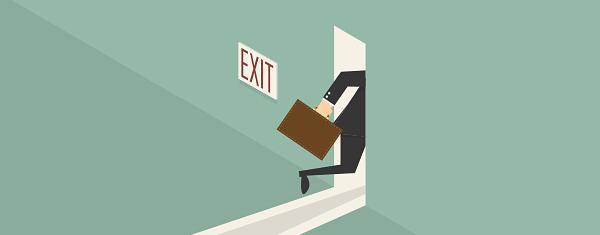

# ML stepik contest

## Задача: 

Анализ оттока студентов с курса "Программирование на языке R" на платформе Stepik. Научиться на ранних этапах определять бросит ли ученик курс или нет

## Описание данных 

events_train.csv - данные о действиях, которые совершают студенты со стэпами
* step_id - id стэпа. 
* user_id - анонимизированный id юзера
* timestamp - время наступления события в формате unix date
* action - событие 

    action может быть:
* discovered - пользователь перешел на стэп
* viewed - просмотр шага,
* started_attempt - начало попытки решить шаг, нужно было нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
* passed - удачное решение практического шага

submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям
* timestamp - время отправки решения в формате unix date
* submission_status - статус решения


## Этапы проекта

1. Обзор и предварительный анализ данных
2. Исследовательский анализ данных и предобработка
3. Модель и кросс-валидация
4. Подготовка ответа по тестовой выборке
5. Выводы по работе с данными

# 1. Обзор и предварительный анализ данных 

In [9]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [10]:
# Загрузка данных с логами действий студентов курса
eve_data_path = '/Users/nikita/Desktop/python_projects/ml_stepik_contest_data/event_data_train.csv'
events_data = pd.read_csv(eve_data_path)

In [11]:
# Загрузка данных о времени и статусах сабмитов к практическим заданиям
sub_data_path = '/Users/nikita/Desktop/python_projects/ml_stepik_contest_data/submissions_data_train.csv'
submissions_data = pd.read_csv(sub_data_path)

In [12]:
events_data.head(2)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632


In [14]:
events_data.shape

(3480703, 4)

In [15]:
events_data.user_id.nunique()

19234

In [16]:
submissions_data.head(2)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853


In [17]:
submissions_data.shape

(509104, 4)

In [18]:
merged = events_data.merge(submissions_data, how='outer')

In [19]:
# Сумма всех пропусков в массиве данных events
events_data.isna().sum().sum() 

0

In [20]:
# Сумма всех пропусков в массиве данных submissions
submissions_data.isna().sum().sum() 

0

In [21]:
# Уникальные значения в колонке  Action
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

### Вывод:
* Пропусков и аномалий в необработанных данных не обнаружено
* Колонка timestamp содержит данные о времени события в unix формате. Её следует перевести в формат Даты для более удобной работы

# 2. Исследовательский анализ данных и предобработка

In [22]:
# Add 'date' column from "timestamp"
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')

In [23]:
# Add column with Date without Time
events_data['day'] = (events_data
                      .date
                      .dt
                      .date
)   

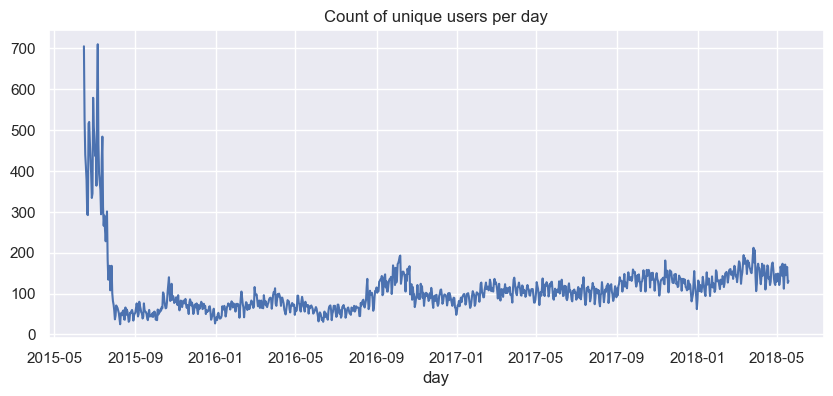

In [24]:
# Graph Count of unique users per day
sns.set(rc = {'figure.figsize': (10,4)}) 
graph = (events_data
    .groupby('day') 
    .user_id
    .nunique()
    .plot()        
)

plt.title('Count of unique users per day');

In [25]:
# Count each type of activity for each User
users_events_data = (
    events_data
        .pivot_table(index='user_id', columns='action', values='step_id',
                     aggfunc='count', fill_value=0)
        .reset_index()
)

In [26]:
users_events_data.head(3)

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192


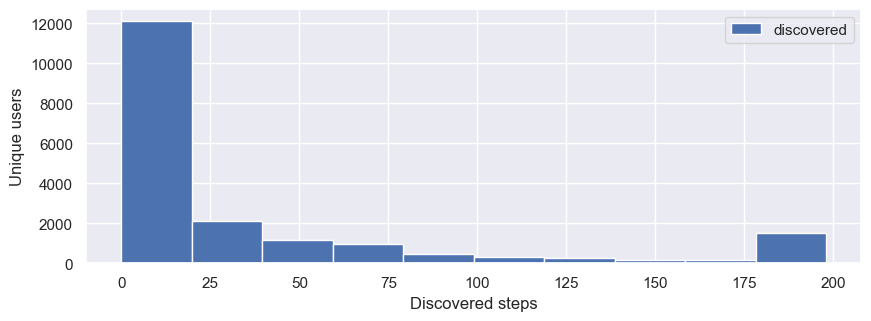

In [27]:
# Hist of discovered steps by users
sns.set(rc = {'figure.figsize': (10, 3.3)})
users_events_data.discovered.hist(legend = 1);

plt.xlabel('Discovered steps')
plt.ylabel('Unique users');

In [28]:
# Add Date and Day columns to Submission data
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head(3)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11


In [29]:
# Count of Correct and Wrong submissions for each User
users_scores = (
    submissions_data
        .pivot_table(index='user_id', aggfunc='count', columns='submission_status',
                     values='step_id', fill_value=0)
        .reset_index()
)

users_scores.head(3)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2


## Hypothesis: 

There is dependance between Count of student inactive Days and the probability that the Student will return.

Let's explore statistics about break duration and Return probability

In [30]:
# gap_data variable with data about the duration of breaks
gap_data = (
    events_data[['user_id', 'day', 'timestamp']]
        .drop_duplicates(subset=['user_id','day'])
        .groupby('user_id')['timestamp']
        .apply(list)
        .apply(np.diff)
        .values
)

gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24*60*60)

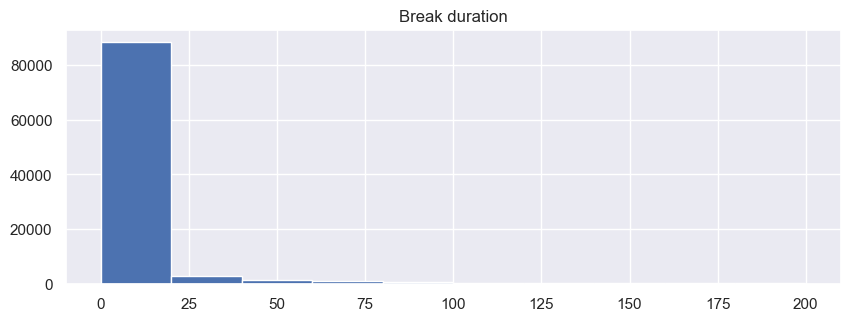

In [31]:
sns.set(rc = {'figure.figsize': (10, 3.3)})
gap_data[gap_data < 200].hist()
plt.title('Break duration');

In [32]:
gap_data.quantile(0.95)

59.760440972222156

In [33]:
gap_data.quantile(0.9)

18.325995370370403

### Вывод: 
* 5% пользователей возвращаются на курс после перерыва более 59 дней
* 10% пользователей возвращаются на курс после перерыва более 18 дней.
* Используем 30 дней - как срок через который юзер считается бросившим курс 

******************************************************************************************************************************

# 3. Модель и кросс-валидация 

* It makes sense to predict student drop as soon as possible. 
* Need to create Features for Model that represents Users behavior in the early stages

## 3.1 Searching for raw Features 

In [34]:
now = events_data.timestamp.max()      # last timestamp
drop_out_treshold = 30 * 24 * 60 * 60      # timestamp equals 1 month

In [35]:
# Lets create DF users_data to collect all usefull info in one place
users_data = (
    events_data
        .groupby('user_id', as_index = False)
        .agg({'timestamp' : 'max'}) 
        .rename(columns = {'timestamp' : "last_timestamp"})
) 

In [36]:
users_data.head(3)

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588


In [37]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

In [38]:
# Add data about correct and wrong subs
users_data = users_data.merge(users_scores, how='outer') 

# Now we have empty cells Because of Theoretical steps has no submissions (empty correct and wrong)
users_data = users_data.fillna(0)  

# Add Users activities Count  data
users_data = users_data.merge(users_events_data, how='outer')

In [39]:
# Unique days count for each user
users_days = (
    events_data
        .groupby('user_id')
        .day.nunique()
        .to_frame()
        .reset_index()
)

In [40]:
# Add Unique days count for each User
users_data = users_data.merge(users_days, how='outer')

In [41]:
# To pass the Course student has to reach 170 points
users_data['passed_course'] = users_data.passed > 170 

In [42]:
user_min_time = (
    events_data
        .groupby('user_id', as_index=0)
        .agg({'timestamp' : 'min'})
        .rename({'timestamp' : 'min_timestamp'}, axis=1)
)

In [43]:
# Create Events_data_train var which contains only first 3 days of each User activity 
users_data = users_data.merge(user_min_time, how='outer')
users_data['threshold_timestamp'] = users_data.min_timestamp + 3*24*60*60
events_data = events_data.merge(users_data[['user_id', 'threshold_timestamp']], how='outer')
events_data_train = events_data[events_data.timestamp <= events_data.threshold_timestamp ]
events_data_train.head(3)

,step_id,timestamp,action,user_id,date,day,threshold_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048


In [44]:
# Create sub_data_train var. which contains only first 3 days of each User Submissions 
submissions_data = submissions_data.merge(users_data[['user_id', 'threshold_timestamp']], how = 'left')
sub_data_train = submissions_data[submissions_data.timestamp <= submissions_data.threshold_timestamp]
sub_data_train.head(3)

,step_id,timestamp,submission_status,user_id,date,day,threshold_timestamp
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434605177
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434605177
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434605177


## 3.2 Feature collection

* Let's create X DataFrame with Features

In [45]:
# First Feature is number of unique 'active' days in first 3 days of Users 
X = sub_data_train.groupby('user_id').day.nunique().to_frame().reset_index()
X.shape

(8913, 2)

In [46]:
# Second Feature 
steps_tried = (
    sub_data_train 
        .groupby('user_id')
        .step_id
        .nunique()
        .to_frame()
        .reset_index()
        .rename(columns={'step_id':'steps_tried'})
    )

In [47]:
X = X.merge(steps_tried, how = 'outer')
X.rename(columns = {'day' : 'days'})
X.head(3)

,user_id,day,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11


In [48]:
# 3-d and 4-th Features is Count of steps with each submission status for each User
X = X.merge(
    sub_data_train
        .pivot_table(index='user_id', columns='submission_status', values='step_id', 
                     aggfunc='count', fill_value=0)
        .reset_index()
)

In [49]:
# 5-th Feature
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [50]:
# 6-9 Features 
X = X.merge(
    events_data_train
        .pivot_table(index = 'user_id', columns = 'action', values = 'step_id', 
                     aggfunc = 'count', fill_value = 0)
        .reset_index()[['user_id', 'viewed']], how = 'outer'
)

In [51]:
X = X.fillna(0)
# 10-12 Features
X = X.merge(users_data[['user_id', 'is_gone_user', "passed_course"]], how='outer')

In [52]:
X.shape

(19234, 9)

In [53]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [54]:
X.shape

(17985, 9)

In [55]:
19234 - 17985 

1249

In [56]:
# Target variable
y = X.passed_course.map(int)

In [57]:
X = X.drop(columns=['is_gone_user','passed_course'])

In [58]:
X = X.set_index(X.user_id)

In [59]:
X = X.drop("user_id", axis=1)

In [60]:
X.head(3)

,day,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.0,9
3,1.0,4.0,4.0,4.0,0.5,20
8,1.0,11.0,9.0,21.0,0.3,154


In [61]:
X_tmp = X.copy()

In [62]:
y_tmp = y.copy()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, random_state= 42)

In [64]:
decision_tree_clf = DecisionTreeClassifier()

In [65]:
params = {'criterion' : ['entropy'], 
          'max_depth' : range(1,10), 
          'min_samples_split' : range(2,10), 
          'min_samples_leaf' : range(1,10),
         }

In [66]:
grid_search = GridSearchCV(decision_tree_clf, param_grid=params, cv=5)

In [67]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)})

In [68]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=9)

In [69]:
best_tree_clf = grid_search.best_estimator_

In [70]:
best_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=9)

In [71]:
from sklearn import tree

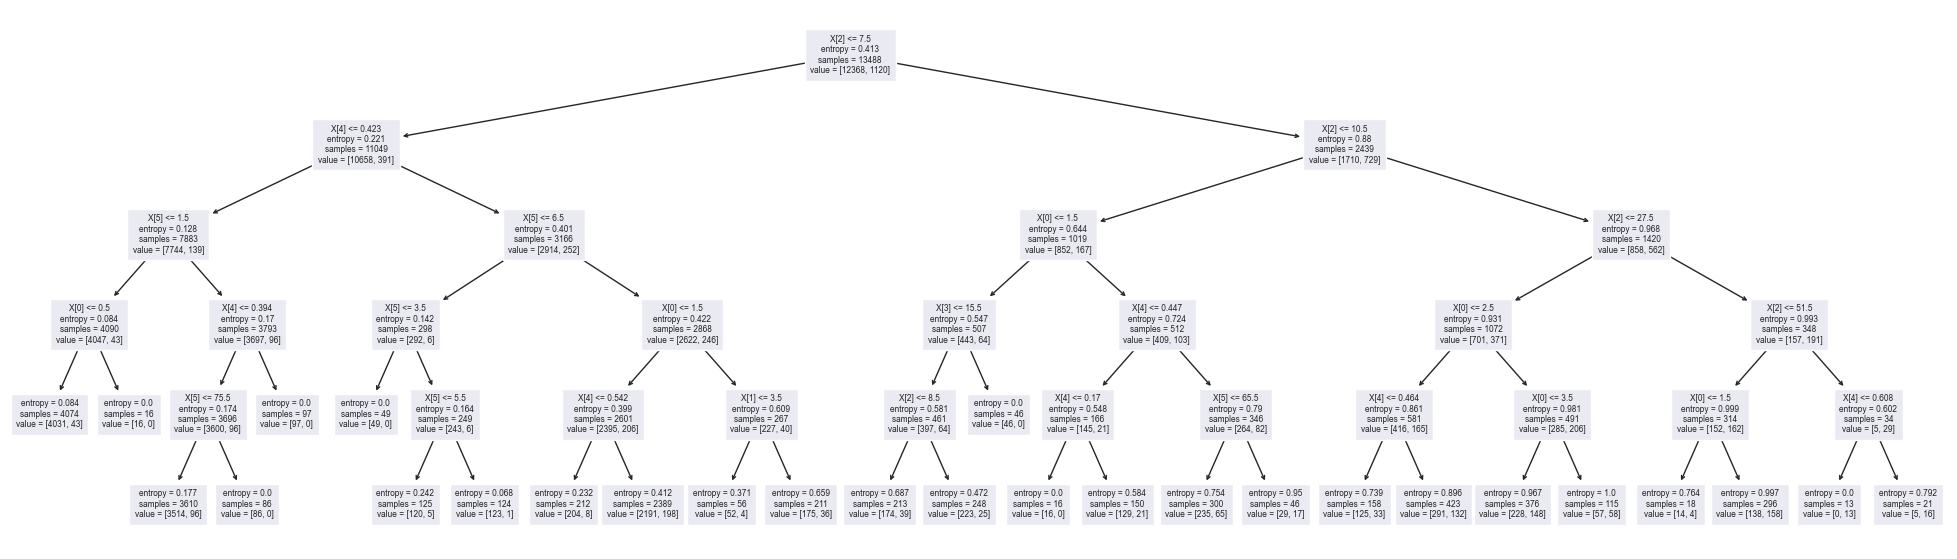

In [72]:
sns.set(rc = {'figure.figsize': (25, 7)})

tree.plot_tree(best_tree_clf, fontsize=6)
plt.show()

In [73]:
best_tree_clf.feature_importances_

array([0.02866279, 0.00198401, 0.80046723, 0.00658006, 0.13140658,
       0.03089934])

In [74]:
y_pred = best_tree_clf.predict(X_test)

In [75]:
confusion_mtrx = confusion_matrix(y_test, y_pred)

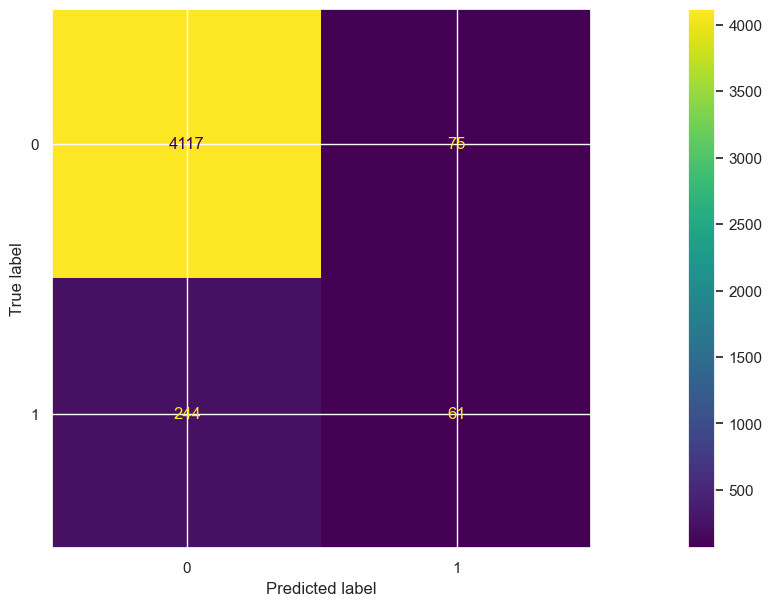

In [76]:
disp = ConfusionMatrixDisplay(confusion_mtrx)
disp.plot()

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4192
           1       0.45      0.20      0.28       305

    accuracy                           0.93      4497
   macro avg       0.70      0.59      0.62      4497
weighted avg       0.91      0.93      0.92      4497

